In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import sigkernel as ksig

In [2]:
num_permutations = 200
n_levels = 5
n_samples = 100
sample_len = 60
dt = 0.1
difference = True

static_kernel = ksig.static.kernels.LinearKernel()
sig_kernel = ksig.kernels.SignatureKernel(n_levels, static_kernel=static_kernel, difference=difference)
kernel = lambda X,Y : sig_kernel(X, Y)
mmd = lambda X,Y : ksig.tests.quadratic_time_mmd(X, Y, kernel)

In [3]:
X = ksig.tests.gen_GBM_path(mu=0.1, sigma=0.2, dt=dt, n_paths=n_samples, seq_len=sample_len)
Y = ksig.tests.gen_GBM_path(0.1, 0.3, dt, n_samples, sample_len)

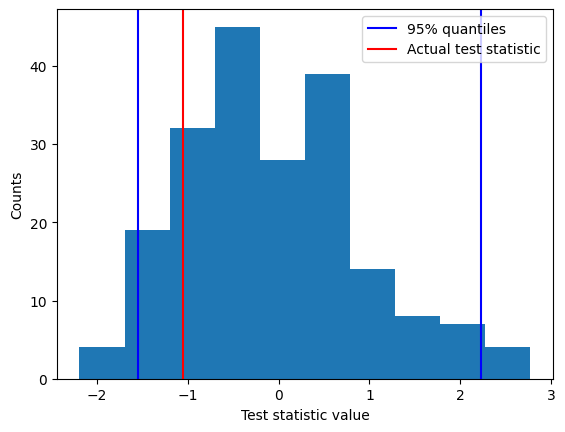

In [4]:
stats_dist = ksig.tests.two_sample_permutation_test(mmd, X, Y, num_permutations)
stats = mmd(X,Y)
ksig.tests.plot_permutation_samples(stats_dist, stats)

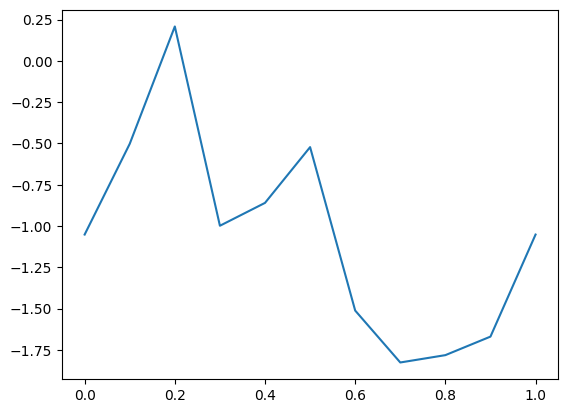

In [5]:
distribution = np.empty((2, 11))
for i in range(11):
    split = i / 10
    index = int(split * n_samples)

    X_ = np.concatenate([X[:index], Y[index:]])
    Y_ = np.concatenate([Y[:index], X[index:]])

    stats = mmd(X_, Y_)
    distribution[0, i] = split
    distribution[1, i] = stats
plt.plot(distribution[0], distribution[1])

In [6]:
sig_kernel(X, X)

array([[1.02266671, 0.98409318, 0.99588818, ..., 1.02689912, 1.02477002,
        1.02197647],
       [0.98409318, 1.07766981, 0.57365885, ..., 0.94040697, 0.97292868,
        0.67176001],
       [0.99588818, 0.57365885, 3.79426404, ..., 1.25714029, 1.05786743,
        3.02132881],
       ...,
       [1.02689912, 0.94040697, 1.25714029, ..., 1.05688552, 1.03533191,
        1.2174473 ],
       [1.02477002, 0.97292868, 1.05786743, ..., 1.03533191, 1.02848109,
        1.06953943],
       [1.02197647, 0.67176001, 3.02132881, ..., 1.2174473 , 1.06953943,
        2.49477962]])

In [7]:
sig_kernel(Y, Y)

array([[24.44077437,  4.34229628,  3.94463194, ...,  2.16445183,
        -0.37975686,  4.72444026],
       [ 4.34229628,  2.10861204,  1.70117981, ...,  1.38583417,
         0.63145333,  1.98931753],
       [ 3.94463194,  1.70117981,  2.19468016, ...,  1.46280109,
         0.38705047,  1.9553231 ],
       ...,
       [ 2.16445183,  1.38583417,  1.46280109, ...,  1.20600533,
         0.7589187 ,  1.43398232],
       [-0.37975686,  0.63145333,  0.38705047, ...,  0.7589187 ,
         1.3170762 ,  0.51064825],
       [ 4.72444026,  1.98931753,  1.9553231 , ...,  1.43398232,
         0.51064825,  2.04326456]])

In [8]:
sig_kernel(X, Y)

array([[1.22374835, 1.13559474, 1.05761983, ..., 1.04516564, 0.96818406,
        1.10551441],
       [0.41239998, 0.82930774, 0.69955688, ..., 0.88111443, 1.1560248 ,
        0.76843197],
       [3.22025619, 1.39450203, 2.6443727 , ..., 1.54849677, 0.15209814,
        1.93508396],
       ...,
       [1.55246431, 1.20910167, 1.22863784, ..., 1.10721565, 0.88008538,
        1.22401818],
       [1.31077897, 1.15966519, 1.10100883, ..., 1.06210127, 0.94568906,
        1.13869442],
       [3.13624028, 1.46656204, 2.27415757, ..., 1.452459  , 0.3427893 ,
        1.82790173]])